In [1]:
##### CLEAN UP STUDIO NAMES #####
STUDIO_CLEANUP_DICT = {
'20th Century Fox Distribution': '20th Century Fox',
'20th Century Fox Film Corporat': '20th Century Fox',
'A24 and DIRECTV': 'A24 / DIRECTV',
'A24 Films': 'A24',
'After Dark Films/Freestyle Releasing': 'After Dark Films / Freestyle Releasing',
'Artisan': 'Artisan Entertainment',
'Buena Vista': 'Buena Vista International',
'Buena Vista Distribution': 'Buena Vista International',
'Buena Vista Distribution Compa': 'Buena Vista International',
'Buena Vista Internationa': 'Buena Vista International',
'Buena Vista Pictures': 'Buena Vista International',
'Cinema Service': 'Cinema Group',
'Columbia Tristar Pictures': 'Columbia Pictures',
'Destination Film': 'Destination Films',
'Dreamworks Distribution LLC': 'Dreamworks Pictures',
'DreamWorks SKG': 'Dreamworks Pictures',
'Dreamworks/Paramount': 'Dreamworks Pictures',
'Fox': '20th Century Fox',
'Fox International': '20th Century Fox',
'Fox Searchlight': '20th Century Fox',
'Fox Searchlight Pictures': '20th Century Fox',
'Gravitas Ventures': 'Gravitas',
'IFC': 'IFC Films',
'IFC First Take': 'IFC Films',
'Independant Pictures': 'Warner Bros.',
'Independent Pictures': 'Warner Bros.',
'Lions Gate': 'Lionsgate',
'Lions Gate Films': 'Lionsgate',
'Lions Gate Films Inc.': 'Lionsgate',
'Film Arcade': 'The Film Arcade',
'Lions Gate Releasing': 'Lionsgate',
'Lionsgate Films': 'Lionsgate',
'Lionsgate Films/After Dark Films': 'Lionsgate / After Dark Films',
'Lionsgate/Roadside Attractions': 'Lionsgate / Roadside Attractions',
'MGM/UA': 'MGM / United Artists',
'Miramax Films': 'Miramax',
'NCM/Fathom': 'NCM Fathom',
'New Line Home Entertainment': 'New Line Cinema',
'Newmarket Film Group': 'Newmarket Films',
'Paramount Classics': 'Paramount',
'Paramount Home Video': 'Paramount',
'Paramount Pictures': 'Paramount',
'Paramount Studios': 'Paramount',
'Paramount Vantage': 'Paramount',
'Screen Gems/SONY PICTURES': 'Screen Gems / Sony Pictures',
'Sony Classics': 'Sony Pictures',
'Sony Pictures Classics': 'Sony Pictures',
'Sony Pictures Entertainment': 'Sony Pictures',
'Sony Pictures Home Entertainment': 'Sony Pictures',
'Sony Pictures Releasing': 'Sony Pictures',
'Sony Pictures/Columbia': 'Sony Pictures / Columbia Pictures',
'Sony Pictures/Columbia Pictures': 'Sony Pictures / Columbia Pictures',
'Sony Pictures/TriStar Pictures': 'Sony Pictures / TriStar Pictures',
'STXfilms': 'STX Entertainment',
'Summit Entertainment.': 'Summit Entertainment',
'Summit Premiere': 'Summit Entertainment',
'The Weinstein Co.': 'The Weinstein Company',
'The Weinstein Company': 'The Weinstein Company',
'Truly Indie/BEV Pictures': 'Truly Indie / BEV Pictures',
'Twentieth Century Fox': '20th Century Fox',
'Twentieth Century Fox Home Entertainment': '20th Century Fox',
'United Artists Pictures': 'United Artists',
'United Artists Pictures/MGM': 'United Artists Pictures / MGM',
'Universal': 'Universal Pictures',
'Universal Pictures Distributio': 'Universal Pictures',
'Universal Pictures International': 'Universal Pictures',
'Universal Studios': 'Universal Pictures',
'Universal Studios Home Video': 'Universal Pictures',
'Walt Disney Animation Studios': 'Walt Disney Pictures',
'Warner Bros. Pictures': 'Warner Bros.',
'WARNER BROTHERS PICTURES': 'Warner Bros.',
'WB': 'Warner Bros.',
'Weinstein Co.': 'The Weinstein Company'}

In [2]:
##### IMPORT ALL PACKAGES #####
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandasql import sqldf
%matplotlib inline
pysqldf = lambda q: sqldf(q, globals())

##### IMPORT ALL DATA #####
df_bom_movie_gross = pd.read_csv('data/bom.movie_gross.csv') # PRIMARY
df_imdb_name_basics = pd.read_csv('data/imdb.name.basics.csv')
df_imdb_title_akas = pd.read_csv('data/imdb.title.akas.csv')
df_imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv') # PRIMARY
df_imdb_title_crew = pd.read_csv('data/imdb.title.crew.csv')
df_imdb_title_principals = pd.read_csv('data/imdb.title.principals.csv')
df_imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv') # PRIMARY
df_rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')
df_rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding= 'unicode_escape')
df_tmdb_movies = pd.read_csv('data/tmdb.movies.csv').drop('Unnamed: 0', axis=1)
df_tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

##### GENRES #####
GENRES_OG = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
GENRES_FULL = [
     'genre_action','genre_adult','genre_adventure','genre_animation','genre_biography','genre_comedy','genre_crime',
     'genre_documentary','genre_drama','genre_family','genre_fantasy','genre_gameshow','genre_history','genre_horror',
     'genre_music','genre_musical','genre_mystery','genre_news','genre_reality_tv','genre_romance','genre_sci_fi',
     'genre_short','genre_sport','genre_talkshow','genre_thriller','genre_war','genre_western']
GENRE_CONVERSION = dict(zip(GENRES_FULL, GENRES_OG))

##### COMBINE AND CLEAN FINANCIAL DATA #####
df_money = df_tn_movie_budgets.loc[:, ['movie', 'production_budget', 'domestic_gross','worldwide_gross']].copy()
production_budget = [float(x.replace('$', '').replace(',','')) for x in df_money.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.worldwide_gross]
df_money = pd.DataFrame([production_budget, domestic_gross, worldwide_gross]).transpose()
df_money.columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
df_money['profit'] = df_money.worldwide_gross - df_money.production_budget
df_money['movie'] = df_tn_movie_budgets.movie
df_money = df_money[['movie','production_budget', 'domestic_gross', 'worldwide_gross', 'profit']]
df_money = df_money.sort_values(by='movie').reset_index(drop=True)
df_genres = df_imdb_title_basics[df_imdb_title_basics['genres'].isna() == False].copy()
for category in GENRES_OG:
    df_genres[category] = [category in x for x in df_genres['genres']]
df_genres.drop(['start_year', 'runtime_minutes', 'genres', 'original_title'], axis=1, inplace=True)

##### CREATE FULL IMDB DB #####
df_imdb = pysqldf(''' SELECT * FROM df_imdb_title_basics basics
LEFT JOIN df_genres genres USING (tconst)
LEFT JOIN df_money money ON basics.primary_title == money.movie
LEFT JOIN df_tmdb_movies tmdb ON basics.primary_title == tmdb.original_title;''')

df_imdb = df_imdb[[
       'tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 
       'production_budget', 'domestic_gross', 'worldwide_gross', 'profit',
       'genre_ids', 'id', 'original_language', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]
df_imdb.columns = ['tconst', 'primary_title', 'DELETE1', 'original_title',
       'DELETE2', 'start_year', 'runtime_minutes', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_news', 'genre_reality_tv', 'genre_romance', 'genre_sci_fi',
       'genre_short', 'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war', 'genre_western']
df_imdb.drop(['DELETE1', 'DELETE2'], axis=1, inplace=True)

In [3]:
genre_counts = {}
for item in df_rt_movie_info.genre.loc[df_rt_movie_info.genre.isna()==False]:
    for sub_item in item.split(sep = '|'):
        if sub_item in genre_counts.keys():
            genre_counts[sub_item] += 1
        else:
            genre_counts[sub_item] = 1
genre_counts = pd.Series(genre_counts).sort_values(ascending=False)
genre_counts

Drama                          912
Comedy                         550
Action and Adventure           366
Mystery and Suspense           309
Art House and International    265
Romance                        198
Classics                       193
Science Fiction and Fantasy    172
Horror                         134
Kids and Family                 99
Musical and Performing Arts     98
Documentary                     69
Special Interest                61
Western                         48
Animation                       47
Television                      23
Faith and Spirituality          11
Sports and Fitness              10
Cult Movies                      4
Anime and Manga                  2
Gay and Lesbian                  2
dtype: int64

In [4]:
#df_rt_reviews.rating.unique() #used to extract the ratings_dirty list below

ratings_dirty = ['3/5', 'C', '2/5', 'B-', '2/4', 'B', '3/4', '4/5', '4/4',
       '6/10', '1/4', '8', '2.5/4', '4/10', '2.0/5', '3/10', '7/10', 'A-',
       '5/5', 'F', '3.5/4', 'D+', '1.5/4', '3.5/5', '8/10', 'B+', '9/10',
       '2.5/5', '7.5/10', '5.5/10', 'C-', '1.5/5', '1/5', '5/10', 'C+',
       '0/5', '6', '0.5/4', 'D', '3.1/5', '3/6', '4.5/5', '0/4', '2/10',
       'D-', '7', '1/10', '3', 'A+', 'A', '4.0/4', '9.5/10', '2.5',
       '2.1/2', '6.5/10', '3.7/5', '8.4/10', '9', '1', '7.2/10', '2.2/5',
       '0.5/10', '5', '0', '2', '4.5', '7.7', '5.0/5', '8.5/10', '3.0/5',
       '0.5/5', '1.5/10', '3.0/4', '2.3/10', '4.5/10', '4/6', '3.5',
       '8.6/10', '6/8', '2.0/4', '2.7', '4.2/10', '5.8', '4', '7.1/10',
       '5/4', 'N', '3.5/10', '5.8/10', 'R', '4.0/5', '0/10', '5.0/10',
       '5.9/10', '2.4/5', '1.9/5', '4.9', '7.4/10', '1.5', '2.3/4',
       '8.8/10', '4.0/10', '2.2', '3.8/10', '6.8/10', '7.3', '7.0/10',
       '3.2', '4.2', '8.4', '5.5/5', '6.3/10', '7.6/10', '8.1/10',
       '3.6/5', '2/6', '7.7/10', '1.8', '8.9/10', '8.9', '8.2/10',
       '8.3/10', '2.6/6', '4.1/10', '2.5/10', 'F+', '6.0/10', '1.0/4',
       '7.9/10', '8.7/10', '4.3/10', '9.6/10', '9.0/10', '4.0', '1.7',
       '7.9', '6.7', '8.0/10', '9.2/10', '5.2', '5.9', '3.7', '4.7',
       '6.2/10', '1/6', '8.2', '2.6/5', '3.4', '9.7', '3.3/5', '3.8/5',
       '1/2', '7.4', '4.8', '1.6/5', '2/2', '1-5', '1.0', '4.3/5', '5/6',
       '9.2', '2.7/5', '4.9/10', '3.0', '3.1', '7.8/10', 'F-', '2.3/5',
       '3.0/10', '3/2', '7.8', '4.2/5', '9.0', '7.3/10', '4.4/5',
       '6.9/10', '0/6', 'T', '6.2', '3.3', '9.8', '8.5', '1.0/5', '4.1',
       '7.1', '3 1/2']

ratings_clean = [6, 'C', 4, 'B-', 5, 'B', 7.5, 8, 10,
       6, 2.5, 8, 6.25, 4, 4, 3, 7, 'A-',
       10, 'F', 8.75, 'D+', 3.75, 7, 8, 'B+', 9,
       5, 7.5, 5.5, 'C-', 3, 2, 5, 'C+',
       0, 6, 1.25, 'D', 6.2, 5, 9, 0, 2,
       'D-', 7, 1, 'unclear', 'A+', 'A', 10, 9.5, 'unclear',
       'unclear', 6.5, 7.4, 8.4, 9, 'unclear', 7.2, 4.4,
       0.5, 'unclear', 0, 'unclear', 'unclear', 7.7, 10, 8.5, 6,
       1, 1.5, 7.5, 2.3, 4.5, 6.67, 'unclear',
       8.6, 7.5, 5, 'unclear', 4.2, 5.8, 'unclear', 7.1,
       10, 'unclear', 3.5, 5.8, 'unclear', 8, 0, 5,
       5.9, 4.8, 3.8, 'unclear', 7.4, 'unclear', 5.75,
       8.8, 4, 'unclear', 3.8, 6.8, 7.3, 7,
       'unclear', 'unclear', 8.4, 10, 6.3, 7.6, 8.1,
       7.2, 3.33, 7.7, 'unclear', 8.9, 8.9, 8.2,
       8.3, 6.5, 4.1, 2.5, 'F+', 6, 2.5,
       7.9, 8.7, 4.3, 9.6, 9, 'unclear', 'unclear',
       7.9, 6.7, 8, 9.2, 5.2, 5.9, 'unclear', 'unclear',
       6.2, 1.667, 8.2, 5.2, 'unclear', 9.7, 6.6, 7.6,
       5, 7.4, 'unclear', 3.2, 10, 'unclear', 'unclear', 8.6, 8.33,
       9.2, 5.4, 4.9, 'unclear', 'unclear', 7.8, 'F-', 4.6,
       3, 10, 7.8, 8.4, 9, 7.3, 8.8,
       6.9, 0, 'unclear', 6.2, 'unclear', 9.8, 8.5, 2, 'unclear',
       7.1, 'unclear']

dict_for_cleaning = dict(zip(ratings_dirty, ratings_clean))
cleaned = []
for item in df_rt_reviews.rating:
    if (str(item) !='nan'):
        cleaned.append(dict_for_cleaning[item])
    else:
        cleaned.append('???')

cleaned_alpha = []
cleaned_numeric = []
for item in cleaned:
    if item == '???':
        cleaned_alpha.append(np.nan)
        cleaned_numeric.append(np.nan)        
    elif str(type(item)) == str(type("-")):
        cleaned_alpha.append(item)
        cleaned_numeric.append(np.nan)
    else:
        cleaned_alpha.append(np.nan)
        cleaned_numeric.append(item)

df_rt_reviews['rating_clean_alpha'] = cleaned_alpha
df_rt_reviews['rating_clean_numeric'] = cleaned_numeric

In [5]:
rating_counts = {}
for item in df_rt_reviews['rating_clean_alpha']:
    if item in rating_counts.keys():
        rating_counts[item] += 1
    else:
        rating_counts[item] = 1
rating_counts = pd.DataFrame(rating_counts.values(), rating_counts.keys()).reset_index()
rating_counts.columns = ['rating', 'count']
rating_counts.drop(rating_counts.loc[rating_counts.rating=='unclear'].index, inplace=True)
rating_counts = rating_counts.sort_values(by='rating', ascending=True).reset_index(drop=True)
#rating_counts.head(60)

In [6]:
df_rt_reviews.loc[df_rt_reviews.fresh == 'rotten', 'fresh'] = 0
df_rt_reviews.loc[df_rt_reviews.fresh == 'fresh', 'fresh'] = 1
df_rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,rating_clean_alpha,rating_clean_numeric
0,3,A distinctly gallows take on contemporary fina...,3/5,1,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",NaN,6.0
1,3,It's an allegory in search of a meaning that n...,NaN,0,Annalee Newitz,0,io9.com,"May 23, 2018",NaN,NaN
2,3,... life lived in a bubble in financial dealin...,NaN,1,Sean Axmaker,0,Stream on Demand,"January 4, 2018",NaN,NaN
3,3,Continuing along a line introduced in last yea...,NaN,1,Daniel Kasman,0,MUBI,"November 16, 2017",NaN,NaN
4,3,... a perverse twist on neorealism...,NaN,1,NaN,0,Cinema Scope,"October 12, 2017",NaN,NaN


In [7]:
df_rt_reviews_simple = pd.DataFrame([df_rt_reviews.id.unique()]).transpose()
df_rt_reviews_simple.columns = ['id']

df_numerics = df_rt_reviews[['id','rating_clean_numeric']].copy().dropna()

MINIMUM_FRESHOMETER = 5
for movie_id in df_rt_reviews_simple.id:
    fresh = df_rt_reviews.loc[df_rt_reviews.id == movie_id, 'fresh']
    if df_rt_reviews.loc[df_rt_reviews.id == movie_id, 'fresh'].size>= MINIMUM_FRESHOMETER:
         df_rt_reviews_simple.loc[df_rt_reviews_simple.id == movie_id, 'fresh'] = fresh.mean()
df_rt_reviews_simple = df_rt_reviews_simple.dropna().reset_index(drop=True)

In [18]:
df_rt_relevant = pysqldf(''' 
SELECT * FROM df_rt_movie_info main
LEFT JOIN df_rt_reviews_simple reviews USING (id);''')
df_rt_relevant.box_office.dropna()

box_office = []
for movie in df_rt_relevant.box_office:
    if movie == None:
        box_office.append(np.nan)
    else:
        box_office.append(float(movie.replace(',','')))
df_rt_relevant['box_office'] = box_office
df_rt_relevant.drop('currency', axis=1, inplace=True)

df_rt_relevant['studio'] = df_rt_relevant['studio'].map(STUDIO_CLEANUP_DICT).fillna(df_rt_relevant['studio'])

studio = []
for movie in df_rt_relevant.studio:
    if movie == None:
        studio.append(np.nan)
    else:
        studio.append(movie)
df_rt_relevant.studio = studio

df_rt_relevant.head(3)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,box_office,runtime,studio,fresh
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,104 minutes,NaN,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",600000.0,108 minutes,Entertainment One,0.631902
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,116 minutes,NaN,0.782609


In [19]:
df_rt_relevant.head(50)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,box_office,runtime,studio,fresh
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,104 minutes,NaN,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",600000.0,108 minutes,Entertainment One,0.631902
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,116 minutes,NaN,0.782609
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,128 minutes,NaN,0.561404
4,7,None,NR,Drama|Romance,Rodney Bennett,Giles Cooper,None,None,NaN,200 minutes,NaN,NaN
5,8,The year is 1942. As the Allies unite overseas...,PG,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,95 minutes,Warner Bros.,0.746667
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",41032915.0,82 minutes,Paramount,0.462963
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",224114.0,123 minutes,Sony Pictures,0.642105
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",134904.0,117 minutes,NaN,0.142857
9,15,When a diamond expedition in the Congo is lost...,PG-13,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,108 minutes,NaN,0.222222


In [20]:
df_studios = pd.DataFrame(df_rt_relevant.studio.unique(), columns=['studio']).drop(0).sort_values(by='studio', ascending=True).reset_index(drop=True)
df_studios


fresh = []
box_office_median = []
box_office_mean = []
box_office_sum = []
movie_ct = []
for s in df_studios['studio']:
    fresh.append(df_rt_relevant.loc[df_rt_relevant['studio']==s, 'fresh'].median())
    box_office_median.append(df_rt_relevant.loc[df_rt_relevant['studio']==s, 'box_office'].median())
    box_office_mean.append(df_rt_relevant.loc[df_rt_relevant['studio']==s, 'box_office'].mean())
    box_office_sum.append(df_rt_relevant.loc[df_rt_relevant['studio']==s, 'box_office'].sum())
    movie_ct.append(df_rt_relevant.loc[df_rt_relevant['studio']==s, 'studio'].size)
    
    
df_studios['fresh'] = fresh
df_studios['box_office_median'] = box_office_median
df_studios['box_office_mean'] = box_office_mean
df_studios['box_office_sum'] = box_office_sum
df_studios['movie_ct'] = movie_ct
df_studios.sort_values(by='movie_ct', ascending=False, inplace=True)

MINIMUM_FILM_CT_TO_CONSIDER = 5
df_studios = df_studios.loc[df_studios['movie_ct']>=MINIMUM_FILM_CT_TO_CONSIDER].copy()
df_studios

,studio,fresh,box_office_median,box_office_mean,box_office_sum,movie_ct
111,Sony Pictures,0.613910,9908198.5,3.636787e+07,1.236507e+09,45
0,20th Century Fox,0.458333,21254983.0,4.384488e+07,1.271501e+09,44
130,Universal Pictures,0.540984,42168445.0,7.822618e+07,2.425012e+09,41
95,Paramount,0.478978,22715908.0,4.809686e+07,1.298615e+09,37
135,Warner Bros.,0.560976,33670798.0,5.116660e+07,1.227998e+09,35
74,Lionsgate,0.411765,13630226.0,1.998668e+07,2.598268e+08,19
87,New Line Cinema,0.445783,33886034.0,2.801656e+07,1.961159e+08,12
60,IFC Films,0.603168,241672.0,3.502698e+07,2.451889e+08,11
25,Columbia Pictures,0.412313,67631157.0,8.198337e+07,5.738836e+08,11
18,Buena Vista International,0.734409,40525262.5,4.191023e+07,2.514614e+08,11


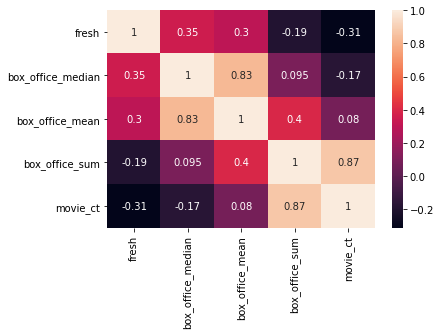

In [21]:
#plt.scatter(df_studios['fresh'], df_studios['box_office_median'])
#plt.show()


df = df_studios.drop('studio', axis=1)
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
# plt.title("Correlation between various studio metrics", fontsize=15)
# plt.show

In [40]:
##### IMPORTANT NOTE #####
THE BELOW CALCULATIONS ARE CLOSE BUT DONT QUITE TAKE INTO ACCOUNT FILMS WITH
MULTIPLE DIRECTORS. YOURE CLOSE -- KEEP GOING.

# df_rt_relevant['director'] = df_rt_relevant['director'].map(DIRECTOR_CLEANUP_DICT).fillna(df_rt_relevant['director'])
# DIRECTOR_CLEANUP_DICT = {
# 'Victor Sarin' : 'Vic Sarin',
# 'Ulrich Edel' : 'Uli Edel',
# 'Tom De Cerchio' : 'Tom DeCerchio',
# 'Rand Ravitch' : 'Rand Ravich',
# 'Rakeysh Omprakesh Mehra' : 'Rakeysh Omprakash Mehra',
# 'Monica Lisa Stambrini' : 'Monica Stambrini',
# 'Matt Tynauer' : 'Matt Tyrnauer',
# 'Jasmine Bizdar' : 'Jasmin Dizdar',
# 'Hammudi al-Rahmoun' : 'Hammudi Al-Rahmoun Font',
# 'Elliott Silverstein' : 'Elliot Silverstein',
# 'Damien Harris' : 'Damian Harris',
# 'Casper Wrede' : 'Caspar Wrede'}

# directors = list(df_rt_relevant.director.unique())

# director_counts_dict = {}
# for item in df_rt_relevant.director.loc[df_rt_relevant.director.isna()==False]:
#     for sub_item in item.split(sep = '|'):
#         if sub_item in director_counts_dict.keys():
#             director_counts_dict[sub_item] += 1
#         else:
#             director_counts_dict[sub_item] = 1
# director_counts_dict
            
# # director_counts_df = pd.Series(director_counts_dict).sort_values(ascending=False)
# # director_counts_df



# df_rt_relevant['director'] = df_rt_relevant['director'].map(DIRECTOR_CLEANUP_DICT).fillna(df_rt_relevant['director'])


# director = []
# for d in df_rt_relevant.director:
#     if d == None:
#         director.append(np.nan)
#     else:
#         director.append(d)
# df_rt_relevant['director'] = director

# df_rt_relevant.head()

# directors = []
# for d in df_directors:
#     d


# # df_directors = pd.DataFrame(df_rt_relevant.director.unique(), columns=['director']).drop(0).sort_values(by='director', ascending=True).reset_index(drop=True)
# # df_directors

# director_counts_dict

{'William Friedkin': 4,
 'David Cronenberg': 1,
 'Allison Anders': 1,
 'Barry Levinson': 4,
 'Rodney Bennett': 1,
 'Jay Russell': 1,
 'Jake Kasdan': 1,
 'Ray Lawrence': 1,
 'Taylor Hackford': 1,
 'Frank Marshall': 1,
 'Peter Baldwin': 1,
 'George Hickenlooper': 2,
 'Rick Rosenthal': 1,
 'Carl Erik Rinsch': 1,
 'Jim Jarmusch': 4,
 'Martyn Burke': 2,
 'Keith Gordon': 1,
 'John Woo': 1,
 'Michael Polish': 1,
 'Roy Ward Baker': 1,
 'David Arquette': 1,
 'John Sayles': 1,
 'Ken Loach': 2,
 'William Wellman': 1,
 'Pauly Shore': 1,
 'Steve Boyum': 1,
 'Peter Cattaneo': 1,
 'Edward Dmytryk': 2,
 'Andy Sidaris': 1,
 'Ivan Nagy': 1,
 'Terence Young': 3,
 'Jon Turteltaub': 1,
 'Paolo Sorrentino': 1,
 'Henning Schellerup': 1,
 'Allen Hughes': 1,
 'Albert Hughes': 1,
 'Woody Allen': 4,
 'Yimou Zhang': 4,
 'Bill Froehlich': 1,
 'James Wong': 2,
 'Pat Proft': 1,
 'Kevin Lima': 1,
 'Niels Arden Oplev': 1,
 'Matt Bettinelli-Olpin': 1,
 'Tyler Gillett': 1,
 'Anatole Litvak': 3,
 'Ira Miller': 1,
 'Steve